In [ ]:
# Instalar librerías necesarias (si no están instaladas)
!pip install numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize



In [ ]:
# ------------------------------------------
# 1. Generar datos sintéticos de retornos (4 activos)
# ------------------------------------------
np.random.seed(42)
n_assets = 4
n_obs = 1000  # Número de observaciones

# Medias y volatilidades de ejemplo
means = np.array([0.08, 0.12, 0.05, 0.15])
volatilities = np.array([0.15, 0.20, 0.10, 0.25])

# Generar retornos correlacionados
corr_matrix = np.array([
    [1.00, 0.30, -0.10, 0.15],
    [0.30, 1.00, 0.20, -0.05],
    [-0.10, 0.20, 1.00, 0.40],
    [0.15, -0.05, 0.40, 1.00]
])

# Crear matriz de covarianza
cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

# Generar retornos sintéticos
returns = np.random.multivariate_normal(means, cov_matrix, n_obs)


In [ ]:
# ------------------------------------------
# 2. Calcular estadísticas clave
# ------------------------------------------
mean_returns = np.mean(returns, axis=0)
cov_matrix_empirical = np.cov(returns, rowvar=False)

print("Retornos esperados anualizados:")
print(np.round(mean_returns*100, 2), "%\n")

print("Matriz de covarianza empírica:")
print(np.round(cov_matrix_empirical, 5))



Retornos esperados anualizados:
[ 8.14 12.51  4.65 14.26] %

Matriz de covarianza empírica:
[[ 0.02323  0.00991 -0.00166  0.00357]
 [ 0.00991  0.04042  0.00365 -0.00228]
 [-0.00166  0.00365  0.00966  0.00924]
 [ 0.00357 -0.00228  0.00924  0.05846]]


In [ ]:
# ------------------------------------------
# 3. Funciones para cálculo de cartera
# ------------------------------------------
def portfolio_stats(weights, mean_ret, cov_matrix):
    """Calcula retorno y volatilidad de la cartera"""
    port_return = np.dot(weights, mean_ret)
    port_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_volatility



In [ ]:
# ------------------------------------------
# 4. Optimización de la cartera de varianza mínima
# ------------------------------------------
def minimize_volatility(mean_ret, cov_matrix):
    n = mean_ret.shape[0]
    args = (mean_ret, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for _ in range(n))

    # Función objetivo: volatilidad
    def objective(w, mean_ret, cov_matrix):
        return portfolio_stats(w, mean_ret, cov_matrix)[1]

    # Punto inicial
    initial_guess = n * [1/n]

    # Optimizar
    opt_result = minimize(objective, initial_guess, args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_result.x

# Encontrar pesos óptimos
optimal_weights = minimize_volatility(mean_returns, cov_matrix_empirical)
opt_return, opt_volatility = portfolio_stats(optimal_weights, mean_returns, cov_matrix_empirical)



In [ ]:
# ------------------------------------------
# 5. Frontera eficiente
# ------------------------------------------
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_portfolios = []

def minimize_volatility_target(mean_ret, cov_matrix, target):
    n = mean_ret.shape[0]
    args = (mean_ret, cov_matrix)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_ret) - target}
    )
    bounds = tuple((0,1) for _ in range(n))

    def objective(w, mean_ret, cov_matrix):
        return portfolio_stats(w, mean_ret, cov_matrix)[1]

    initial_guess = n * [1/n]
    opt_result = minimize(objective, initial_guess, args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_result.x

for ret in target_returns:
    weights = minimize_volatility_target(mean_returns, cov_matrix_empirical, ret)
    port_ret, port_vol = portfolio_stats(weights, mean_returns, cov_matrix_empirical)
    efficient_portfolios.append((port_vol, port_ret))



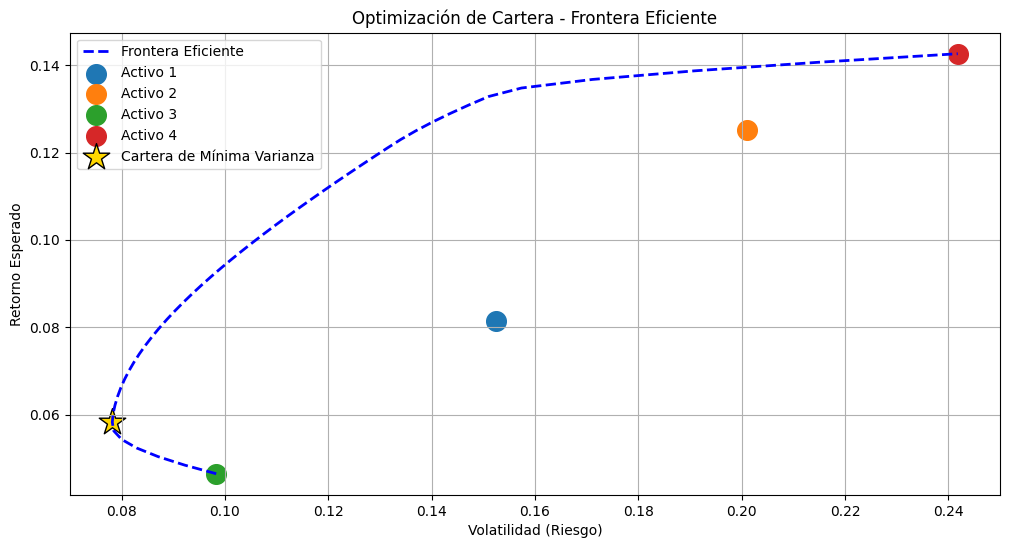

In [ ]:
# ------------------------------------------
# 6. Visualización
# ------------------------------------------
plt.figure(figsize=(12, 6))

# Frontera eficiente
vols = [p[0] for p in efficient_portfolios]
rets = [p[1] for p in efficient_portfolios]
plt.plot(vols, rets, 'b--', linewidth=2, label='Frontera Eficiente')

# Activos individuales
for i in range(n_assets):
    plt.scatter(np.sqrt(cov_matrix_empirical[i,i]), mean_returns[i], marker='o', s=200, label=f'Activo {i+1}')

# Cartera óptima
plt.scatter(opt_volatility, opt_return, marker='*', color='gold', s=400, label='Cartera de Mínima Varianza', edgecolors='black')

plt.title('Optimización de Cartera - Frontera Eficiente')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# ------------------------------------------
# 7. Resultados numéricos
# ------------------------------------------
print("\nPesos óptimos de la cartera de mínima varianza:")
for i, w in enumerate(optimal_weights):
    print(f"Activo {i+1}: {w*100:.2f}%")

print(f"\nRetorno esperado: {opt_return*100:.2f}%")
print(f"Volatilidad: {opt_volatility*100:.2f}%")


Pesos óptimos de la cartera de mínima varianza:
Activo 1: 30.57%
Activo 2: 1.53%
Activo 3: 67.90%
Activo 4: 0.00%

Retorno esperado: 5.83%
Volatilidad: 7.82%
